# basis
> Routines for all basis functions to expand edge features

In [ ]:
#| default_exp basis

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import test_close, test_eq

In [ ]:
#| export
import torch

In [ ]:
#| export
class GaussianSmearing(torch.nn.Module):
    """
    Convert Scalar distances into Gaussian basis functions
    """
    def __init__(self, 
                 start=0.0, # Start of Gaussian basis functions
                 stop=1.0, # stop of the Gaussian basis functions
                 num_basis=8 # Number of Gaussian basis functions
                 ):
        super().__init__()
        offset = torch.linspace(start, stop, num_basis)
        self.coeff = -0.5 / torch.pow((offset[1] - offset[0]), 2)
        self.register_buffer('offset', offset) # Register offset as a buffer. This is a tensor that is not a parameter

    def forward(self, 
                distances # Tensor of distances
                ):
        distances = distances[..., None] - self.offset # This operation aligns the distances with each Gaussian center.
        return torch.exp(self.coeff * torch.pow(distances, 2))

You can get gaussian features from scalar distances by calling the GaussianSmearing Class

In [ ]:
methane_distances = torch.Tensor([[0.        , 1.08253175, 1.08253175 ,1.08253175 ,1.08253175],
 [1.08253175, 0.        , 1.76776695, 1.76776695, 1.76776695],
 [1.08253175, 1.76776695, 0.        , 1.76776695, 1.76776695],
 [1.08253175, 1.76776695, 1.76776695, 0.        , 1.76776695],
 [1.08253175, 1.76776695, 1.76776695, 1.76776695, 0.        ]]
) # these are the distances from the methane example in atoms to graphs
gaussian_smearing = GaussianSmearing(num_basis=8)
g_features = gaussian_smearing(methane_distances)

View them just to make sure. By symmetry, hydrogens have all the same features.

<matplotlib.legend.Legend>

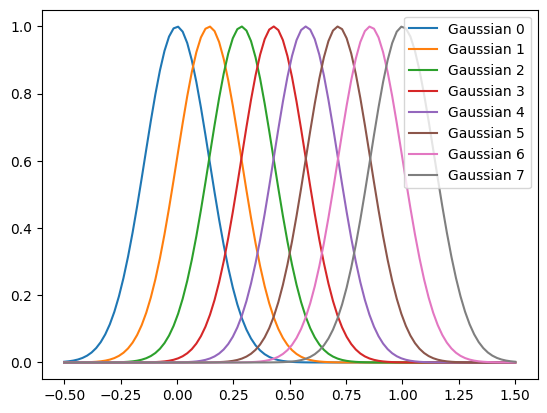

In [ ]:
import matplotlib.pyplot as plt

distances = torch.linspace(-0.5, 1.5, 100) # view from -0.5 to 1.5 in 100 steps
gaussian_smearing = GaussianSmearing(num_basis=8)
g_features = gaussian_smearing(distances) # g_features is a tensor of shape (100, 4)

fig, ax = plt.subplots()
for i in range(g_features.shape[1]):
    ax.plot(distances, g_features[:,i], label=f'Gaussian {i}')
ax.legend()

In [ ]:
#| hide
gaussian_smearing_distances = torch.Tensor([1.0000e+00, 6.0653e-01, 1.3534e-01, 1.1109e-02, 3.3546e-04, 3.7267e-06,
         1.5230e-08, 2.2897e-11])
test = gaussian_smearing(methane_distances)[0][0]
test_close(test.numpy(), gaussian_smearing_distances.numpy())

In [ ]:
#| export
def bessel_features(distances, # Torch tensor of distances
                    start=0.0,
                    stop=1.0,
                    eps=1e-5,
                    num_basis=4 # Number of Bessel basis functions
                    ):
    """
    Convert Scalar distances into Bessel basis functions
    """
    distances = distances[..., None] - start + eps
    c = stop - start
    bessel_roots = torch.arange(1, num_basis + 1) * torch.pi 
    return (2/c)**0.5 * torch.sin(bessel_roots * distances / c) / distances

<matplotlib.legend.Legend>

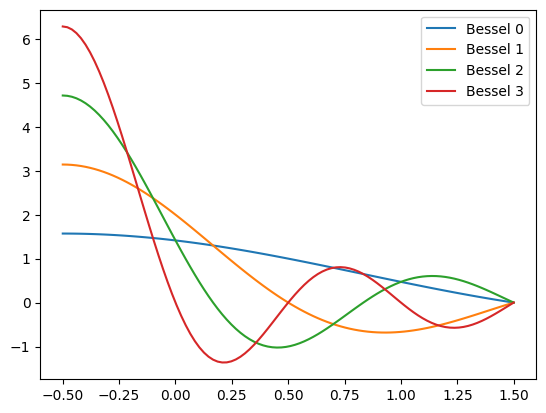

In [ ]:
distances = torch.linspace(-0.5, 1.5, 100) # view from -0.5 to 1.5 in 100 steps
features = bessel_features(distances, start=-0.5, stop=1.5, num_basis=4) # calculate bessel features
# features is of shape  [100, 4] # steps from linspace and num_basis
fig, ax = plt.subplots()
for i in range(features.shape[1]):
    ax.plot(distances, features[:,i], label=f'Bessel {i}')
ax.legend()

In [ ]:
#| export
class GaussianRandomFourierFeatures(torch.nn.Module):
    """Gaussian random Fourier features from the paper titled
    'Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains'.
    Reference: https://arxiv.org/abs/2006.10739
    """
    def __init__(self, 
                 embed_dim, # Embedding dimension. B gets cut in half because GRFF is a concat of cos and sin
                 input_dim=1, # Input dimension
                 sigma=1.0 # variance
                 ):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.B = torch.nn.Parameter(torch.randn(input_dim, embed_dim//2) * sigma, requires_grad=False)
    def forward(self, v):
        v_proj =  2 * torch.pi * v * self.B
        return torch.cat([torch.cos(v_proj), torch.sin(v_proj)], dim=-1)

`GaussianRandomFourierFeatures` won't look like much when plotted since they are being randomly sampled from a gaussian distribution and then being multiplied by Cos/Sin. However, we can view them just to make sure.

<matplotlib.legend.Legend>

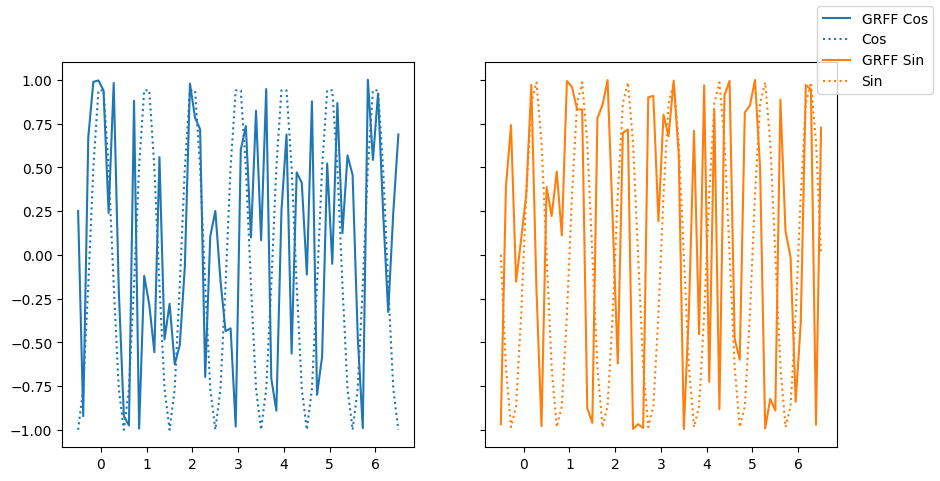

In [ ]:
grff = GaussianRandomFourierFeatures(embed_dim=128, input_dim=1)
v = torch.linspace(-0.5, 6.5, 64)
values = grff(v)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.plot(v, values[0][0:64], c='C0', label="GRFF Cos")
ax1.plot(v, torch.cos(2 * torch.pi * v), label='Cos', c='C0', ls="dotted")
ax2.plot(v, values[0][64:128], c='C1', label="GRFF Sin")
ax2.plot(v, torch.sin(2 * torch.pi * v), label='Sin', c='C1', ls="dotted")
fig.legend()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export() 